In [1]:
%matplotlib widget

import ipywidgets as widgets
from ipywidgets import HBox, VBox, jslink, Box, Layout
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from scipy.signal import TransferFunction, bode, lsim, lti
from scipy import signal
from scipy.integrate import solve_ivp
from IPython.display import display, Latex, Markdown, Image, Math

In [2]:
def make_box_layout():
     return widgets.Layout(
        border='solid 1px black',
        margin='0px 5px 5px 0px',
        padding='2px 2px 2px 2px'
     )

In [3]:
class Regler2Pkt:
    def __init__(self, setPoint, hyst, minOut, maxOut):
        self.setPoint = setPoint
        self.hyst = hyst
        self.minOut = minOut
        self.maxOut = maxOut
        self.state = None
    
    def reset(self):
        self.state = None
    
    def regel(self, curValue):
        if self.state is None:
            if curValue > self.setPoint:
                self.state = True
            else:
                self.state = False
                
        if self.state == False and curValue > self.setPoint + self.hyst:
            self.state = True
        elif self.state == True and curValue < self.setPoint - self.hyst:
            self.state = False
        
        if self.state:
            out = self.minOut
        else:
            out = self.maxOut
            
        return out   

## Zweipunktregler

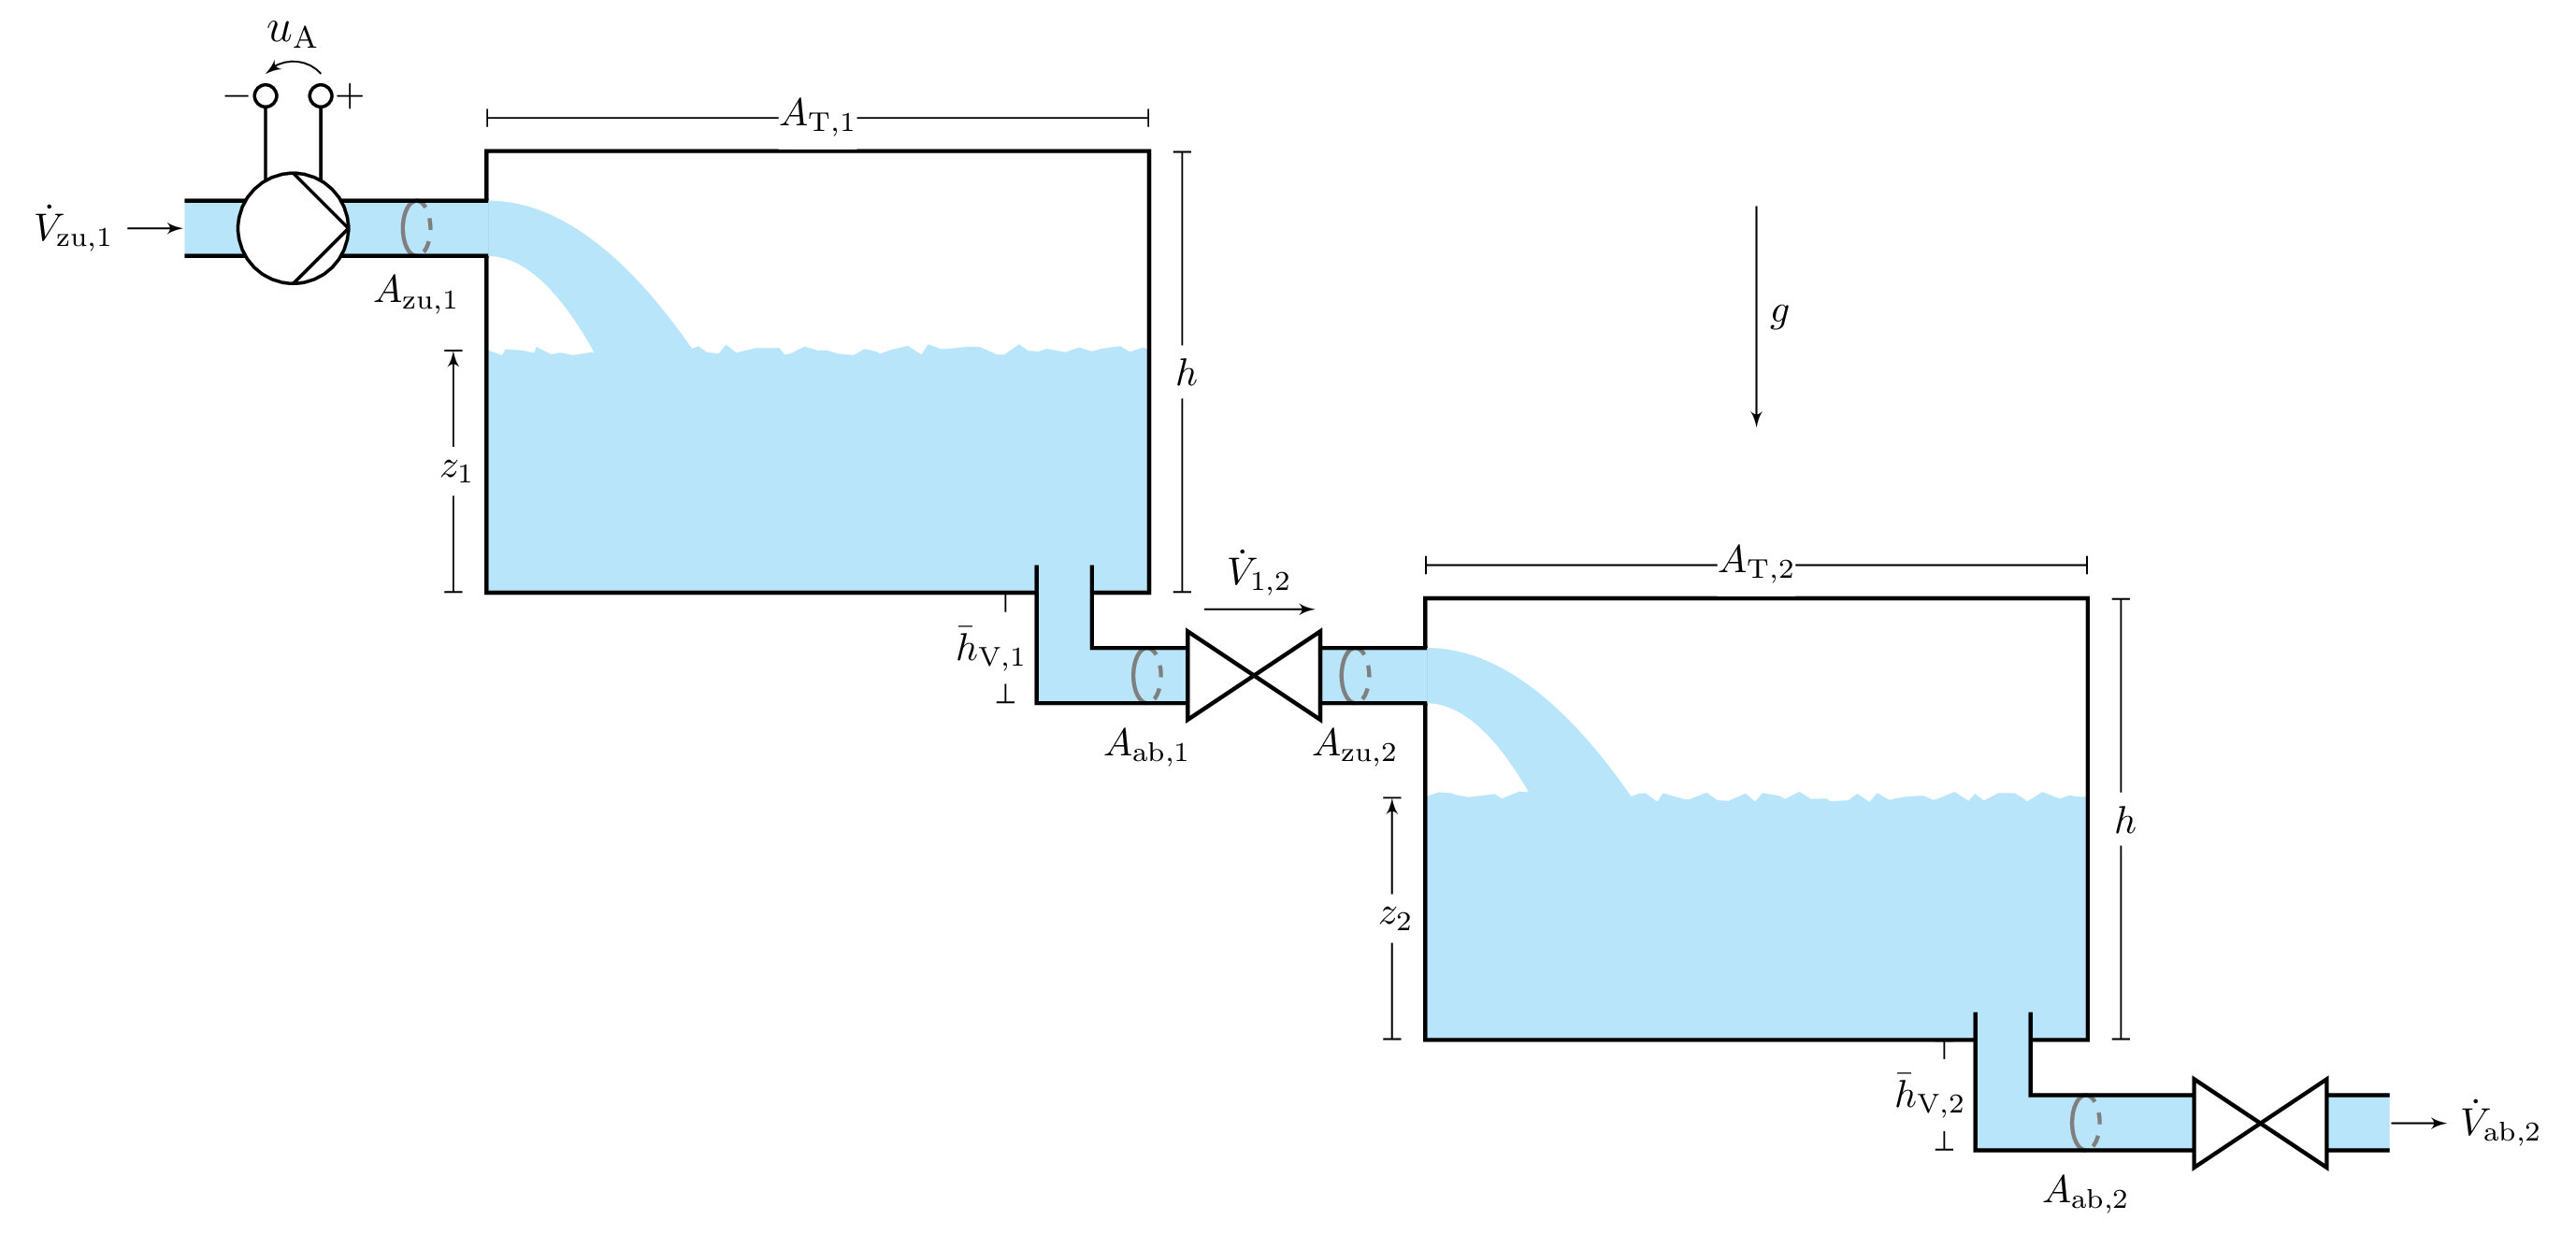

In [4]:
imag = Image("../../images/zweitank.png", width=800)
display(imag)

## 2-Tanksystem

- lineares Modell im Zeitbereich
    \begin{align*}
        \dot{\tilde{z}}_1(t) & = a_{11} \tilde{z}_1(t) + b \tilde{u}_{\text{A}}(t)\\
        \dot{\tilde{z}}_2(t) & = a_{21} \tilde{z}_1(t) + a_{22} \tilde{z}_2(t) 
    \end{align*}
    mit Ausgang $y(t) = \tilde{z}_2(t)$ bzw.
    \begin{align*}
        T_1T_2\ddot{\tilde{z}}_2(t) + (T_1 + T_2)\dot{\tilde{z}}_2(t) + \tilde{z}_2(t) & = K \tilde{u}_{\text{A}}(t)
    \end{align*}
- lineares Modell im Bildbereich
    \begin{align*}
        P(s) &= \frac{\tilde{Z}_2(s)}{\tilde{U}_{\text{A}}(s)} = \frac{K_\mathrm{S}}{(1 + T_1 s) (1 + T_2 s)} = \frac{0.15}{(1 + 68.21 s) (1 + 34.57 s)}
    \end{align*}

__Definition Parammeter__

In [5]:
tSim = np.linspace(0, 1000, 1001)

In [6]:
A = np.array([[-0.0289, 0], [0.0289, -0.0146]])
b = np.array([[0.0021], [0]])
c = np.array([[0], [1]])
KS = 0.15

## Simulation

In [7]:
def prozess(t, x, A, b, u):
    dx = A @ x + (b * u).flatten()

    return dx

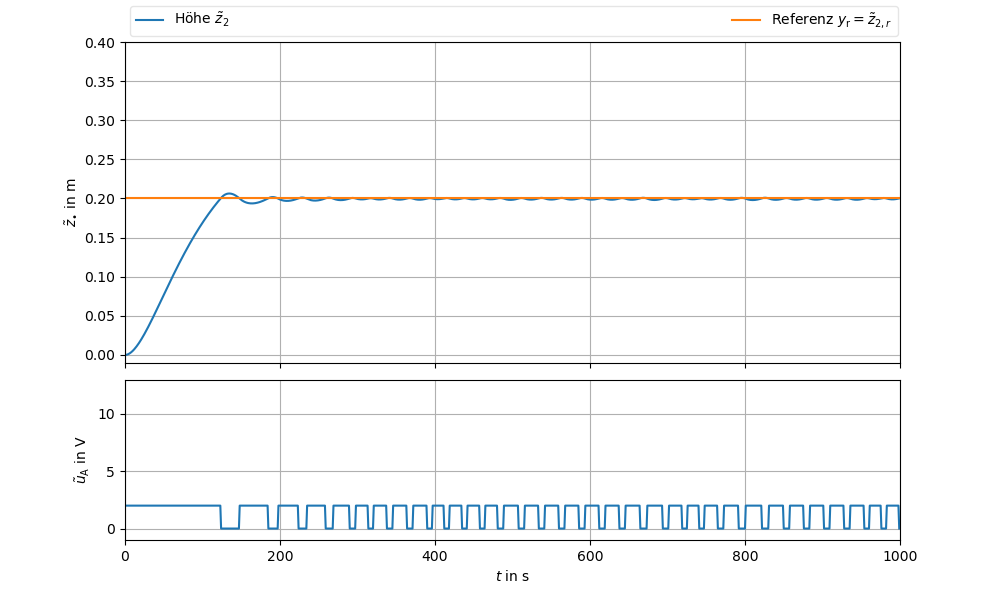

In [9]:
output = widgets.Output()

with output:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

plt.subplots_adjust(wspace=0.2, hspace=0.07)
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.subplots_adjust(bottom=0.1, top=0.93, left=0.125, right=0.9)

ax1.set_xlim([0, tSim[-1]]) 
ax2.set_xlim([0, tSim[-1]])
ax1.set_ylim([-0.01, 0.40])
ax2.set_ylim([-1, 13]) 
ax1.grid() 
ax2.grid()
ax1.set_ylabel(r"$\tilde{z}_{\bullet}$ in m")
ax2.set_ylabel(r"$\tilde{u}_{\mathrm{A}}$ in V")
ax2.set_xlabel(r"$t$ in s")

ySys, = ax1.plot([], [], label=r'Höhe $\tilde{z}_{2}$')
yRefSys, = ax1.plot([], [], 'C1', label=r'Referenz $y_\mathrm{r} = \tilde{z}_{2,r}$')
uSys, = ax2.plot([], [], label=r'Regler $u_{\mathrm{r}}$')

handlesAx, labelsAx = ax1.get_legend_handles_labels()
fig.legend([handle for i, handle in enumerate(handlesAx)],
           [label for i, label in enumerate(labelsAx)],
           bbox_to_anchor=(0.13, 0.94, 0.7675, .15), loc=3,
           ncol=3, mode="expand", borderaxespad=0., framealpha=0.5)

sliderYr = widgets.FloatSlider(value=0.2,
                               min=0,
                               max=0.3,
                               step=0.05,
                               description=r'$\tilde{z}_{2,\mathrm{r}}$')
checkHyst = widgets.Checkbox(value=False,
                             description=r'Hysteres',
                             disabled=False)
sliderYL = widgets.FloatSlider(value=0.01,
                               min=0,
                               max=0.1,
                               step=0.01,
                               description=r'$y_\mathrm{Hyst}$')
sliderUMax = widgets.FloatSlider(value=2,
                                 min=0,
                                 max=12,
                                 step=0.5,
                                 description=r'$u_\mathrm{max}$')

def calcSystem(_):
    yR = sliderYr.value
    uMax = sliderUMax.value
    sliderYr.max = KS * uMax
    
    if checkHyst.value:
        sliderYL.layout.visibility = 'visible'
        yL = sliderYL.value
    else:
        sliderYL.layout.visibility = 'hidden'
        yL = 0
    
    regler = Regler2Pkt(yR, yL, 0, uMax)
        
    x0 = np.array([0, 0])
    yRes = [0]
    uRes = []
    regler.reset()
    for idx, x in enumerate(tSim[1:]):
        u = regler.regel(yRes[-1])
        res = solve_ivp(prozess,
                    [tSim[idx], tSim[idx+1]],
                    x0,
                    args=(A, b, u))
        x0 = res.y.T[-1, :]
        y = res.y.T[-1, 1]
        yRes.append(y)
        uRes.append(u)

    uSys.set_data(tSim[:-1], uRes)
    ySys.set_data(tSim, yRes)
    yRefSys.set_data(tSim[[0, -1]], np.array([yR, yR]))

    fig.canvas.draw()

sliderYr.observe(calcSystem, names='value')
checkHyst.observe(calcSystem, names='value')
sliderYL.observe(calcSystem, names='value')
sliderUMax.observe(calcSystem, names='value')

calcSystem(_)

contControls = HBox([sliderYr, sliderUMax, checkHyst, sliderYL])
contControls.layout = make_box_layout()

controls = HBox([contControls])
VBox([controls, output], layout=Layout(display='flex', flex_flow='row', justify_content='center', align_items='center'))